### Description

### load 

In [1]:
import os
import random 
import pickle
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

root_path = os.path.dirname(os.path.dirname(os.path.abspath(os.getcwd())))
# to import src is necessary to append the root_path to the path
#sys.path.append(root_path)

data_path = os.path.join(root_path,'data')
results_path = os.path.join(root_path,'results')

### Define global variables

In [2]:
WITH_STEMMING = True
REMOVE_STOPWORDS = True
MINIMUM_WORDS_PER_PHRASE = 0
GROUP = -1
SEED = 10
num_topics = 60
random.seed(SEED)

In [3]:
df = pd.read_excel('IBL_topic_distribution_by_block_cooccurrence_minimum_0_words_with_stemming.xlsx')

In [4]:
df.columns

Index(['Topic 1', 'Topic 2', 'Topic 3', 'Topic 4', 'Topic 5', 'Topic 6',
       'Topic 7', 'Topic 8', 'Topic 9', 'Topic 10',
       ...
       'Topic 60-Topic 59', 'phase', 'phase_1', 'phase_2', 'phase_3',
       'phase_4', 'phase_5', 'utterance', 'length utterance',
       'utterance_relative_time'],
      dtype='object', length=1839)

### split dataset

In [5]:
the_keys = list(set(df['phase']))
for key in the_keys:
    n = list(df.phase.values).count(key)
    print("key {}, total {}".format(key,n))

key 1, total 95
key 2, total 41
key 3, total 119
key 4, total 40
key 5, total 157


In [6]:
trainset = {}
testset = {}
for name, group in df.groupby(['phase']):
    trainset[name]=[]
    testset[name]=[]
    n = len(group)
    ra = random.sample(range(n),int(n*0.2))
    print("test set phase {}: {}".format(name,int(n*0.2)))
    count = 0
    group = group.reset_index()
    for i,row in group.iterrows():
        if i in ra:
            count+=1
            testset[name].append(row.values)
        else:
            trainset[name].append(row.values)


test set phase 1: 19
test set phase 2: 8
test set phase 3: 23
test set phase 4: 8
test set phase 5: 31


In [7]:
filter_rows = list(range(1,1831))+[1838,1839]
#filter_labels = [3601]

In [8]:
def get_data_from_dict(a_dict):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            y.append(key)
    return X,y

In [9]:
X_train,y_train = get_data_from_dict(trainset)
X_test,y_test = get_data_from_dict(testset)

In [10]:
print(y_test.count(4))
print(len(X_train[0]))

8
1832


### Train decision tree


In [11]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier(random_state=SEED).fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.47


In [12]:
import graphviz
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

In [13]:
dot_data = tree.export_graphviz(clf, class_names=['1', '2','3','4','5'], out_file=None,max_depth=3)
graph = graphviz.Source(dot_data)
graph.render('test-output/tree_phases_5_classes_co_occurrance_block.gv', view=True)

'test-output/tree_phases_5_classes_co_occurrance_block.gv.pdf'

In [14]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[ 6  1  4  0  8]
 [ 1  1  0  3  3]
 [ 3  1 17  0  2]
 [ 1  1  2  1  3]
 [ 6  4  1  3 17]]
              precision    recall  f1-score   support

           1       0.35      0.32      0.33        19
           2       0.12      0.12      0.12         8
           3       0.71      0.74      0.72        23
           4       0.14      0.12      0.13         8
           5       0.52      0.55      0.53        31

   micro avg       0.47      0.47      0.47        89
   macro avg       0.37      0.37      0.37        89
weighted avg       0.46      0.47      0.47        89



### Train without stem

In [15]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV

In [16]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.64
Accuracy of K-NN classifier on test set: 0.49


In [17]:
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[10  2  2  0  5]
 [ 0  0  2  2  4]
 [ 5  0 18  0  0]
 [ 1  0  2  1  4]
 [ 9  0  5  2 15]]
              precision    recall  f1-score   support

           1       0.40      0.53      0.45        19
           2       0.00      0.00      0.00         8
           3       0.62      0.78      0.69        23
           4       0.20      0.12      0.15         8
           5       0.54      0.48      0.51        31

   micro avg       0.49      0.49      0.49        89
   macro avg       0.35      0.38      0.36        89
weighted avg       0.45      0.49      0.47        89



In [18]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.79
Accuracy of GNB classifier on test set: 0.27


In [19]:
pred = gnb.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3 4 2 2 8]
 [2 2 0 3 1]
 [6 3 8 3 3]
 [2 1 1 3 1]
 [8 2 9 4 8]]
              precision    recall  f1-score   support

           1       0.14      0.16      0.15        19
           2       0.17      0.25      0.20         8
           3       0.40      0.35      0.37        23
           4       0.20      0.38      0.26         8
           5       0.38      0.26      0.31        31

   micro avg       0.27      0.27      0.27        89
   macro avg       0.26      0.28      0.26        89
weighted avg       0.30      0.27      0.28        89



C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)

print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [20]:
svm = SVC(decision_function_shape='ovr',gamma=1,kernel='rbf',random_state=SEED,C= 100.0)#class_weight={1:0.8,2:0.4,3:0.7,5:1})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.92
Accuracy of SVM classifier on test set: 0.54


In [21]:
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[14  2  1  0  2]
 [ 2  0  0  4  2]
 [ 4  0 16  1  2]
 [ 1  1  1  1  4]
 [ 4  4  3  3 17]]
              precision    recall  f1-score   support

           1       0.56      0.74      0.64        19
           2       0.00      0.00      0.00         8
           3       0.76      0.70      0.73        23
           4       0.11      0.12      0.12         8
           5       0.63      0.55      0.59        31

   micro avg       0.54      0.54      0.54        89
   macro avg       0.41      0.42      0.41        89
weighted avg       0.55      0.54      0.54        89



In [22]:
from sklearn.svm import LinearSVC
svc = LinearSVC(random_state=SEED,max_iter=3000)#,class_weight={1:0.4,2:0.4,3:0.4,4:0.5,5:0.3})
svc.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svc.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svc.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.61
Accuracy of SVM classifier on test set: 0.55


In [23]:
pred = svc.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[11  0  3  0  5]
 [ 1  0  1  2  4]
 [ 5  0 14  0  4]
 [ 0  0  1  1  6]
 [ 6  0  2  0 23]]
              precision    recall  f1-score   support

           1       0.48      0.58      0.52        19
           2       0.00      0.00      0.00         8
           3       0.67      0.61      0.64        23
           4       0.33      0.12      0.18         8
           5       0.55      0.74      0.63        31

   micro avg       0.55      0.55      0.55        89
   macro avg       0.41      0.41      0.39        89
weighted avg       0.50      0.55      0.51        89



C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Optimize params

### Build classifier per class

In [24]:
def get_data_from_dict_filter(a_dict,filter_phase):
    y = []
    X = []
    for key in a_dict:
        rows = a_dict[key]
        for row in rows:
            X.append(row[filter_rows])
            if filter_phase == key:
                y.append(key)
            else:
                y.append(0)
    return X,y

### classify class 1

In [25]:
#trainset,testset = split_sets_key(clean_phrases,1)
X_train,y_train = get_data_from_dict_filter(trainset,1)
X_test,y_test = get_data_from_dict_filter(testset,1)

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [26]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.86
Accuracy of SVM classifier on test set: 0.76
[[61  9]
 [12  7]]
              precision    recall  f1-score   support

           0       0.84      0.87      0.85        70
           1       0.44      0.37      0.40        19

   micro avg       0.76      0.76      0.76        89
   macro avg       0.64      0.62      0.63        89
weighted avg       0.75      0.76      0.76        89



In [27]:
svm = LinearSVC(random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.84
Accuracy of SVM classifier on test set: 0.81
[[68  2]
 [15  4]]
              precision    recall  f1-score   support

           0       0.82      0.97      0.89        70
           1       0.67      0.21      0.32        19

   micro avg       0.81      0.81      0.81        89
   macro avg       0.74      0.59      0.60        89
weighted avg       0.79      0.81      0.77        89



### classify class 2

In [28]:
X_train,y_train = get_data_from_dict_filter(trainset,2)
X_test,y_test = get_data_from_dict_filter(testset,2)


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [29]:
svm = SVC(decision_function_shape='ovr',gamma='scale',C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 1.00
Accuracy of SVM classifier on test set: 0.84
[[75  6]
 [ 8  0]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.91        81
           2       0.00      0.00      0.00         8

   micro avg       0.84      0.84      0.84        89
   macro avg       0.45      0.46      0.46        89
weighted avg       0.82      0.84      0.83        89



### Classify class 3

In [30]:
X_train,y_train = get_data_from_dict_filter(trainset,3)
X_test,y_test = get_data_from_dict_filter(testset,3)

In [31]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.87
Accuracy of SVM classifier on test set: 0.87
[[62  4]
 [ 8 15]]
              precision    recall  f1-score   support

           0       0.89      0.94      0.91        66
           3       0.79      0.65      0.71        23

   micro avg       0.87      0.87      0.87        89
   macro avg       0.84      0.80      0.81        89
weighted avg       0.86      0.87      0.86        89



### Classify class 4

In [32]:
X_train,y_train = get_data_from_dict_filter(trainset,4)
X_test,y_test = get_data_from_dict_filter(testset,4)
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.95
Accuracy of SVM classifier on test set: 0.85
[[75  6]
 [ 7  1]]
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        81
           4       0.14      0.12      0.13         8

   micro avg       0.85      0.85      0.85        89
   macro avg       0.53      0.53      0.53        89
weighted avg       0.85      0.85      0.85        89



### classify class 5

In [33]:
X_train,y_train = get_data_from_dict_filter(trainset,5)
X_test,y_test = get_data_from_dict_filter(testset,5)
print(y_train.count(0)*100.0/len(y_train))

65.2892561983471


C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))


In [34]:
svm = SVC(decision_function_shape='ovr',gamma=1e-05,C= 10000000.0, random_state=SEED)#,class_weight={0:0.3,1:0.7})
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))
pred = svm.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

Accuracy of SVM classifier on training set: 0.79
Accuracy of SVM classifier on test set: 0.73
[[51  7]
 [17 14]]
              precision    recall  f1-score   support

           0       0.75      0.88      0.81        58
           5       0.67      0.45      0.54        31

   micro avg       0.73      0.73      0.73        89
   macro avg       0.71      0.67      0.67        89
weighted avg       0.72      0.73      0.72        89



#### Regression


In [35]:
%matplotlib inline  
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [36]:
#clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42,class_weight={0:0.36,5:0.63}).fit(X_train, y_train)
clf = LogisticRegression(solver='liblinear', max_iter=1000, random_state=42).fit(X_train, y_train)

In [37]:
pred = clf.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[57  1]
 [25  6]]
              precision    recall  f1-score   support

           0       0.70      0.98      0.81        58
           5       0.86      0.19      0.32        31

   micro avg       0.71      0.71      0.71        89
   macro avg       0.78      0.59      0.57        89
weighted avg       0.75      0.71      0.64        89



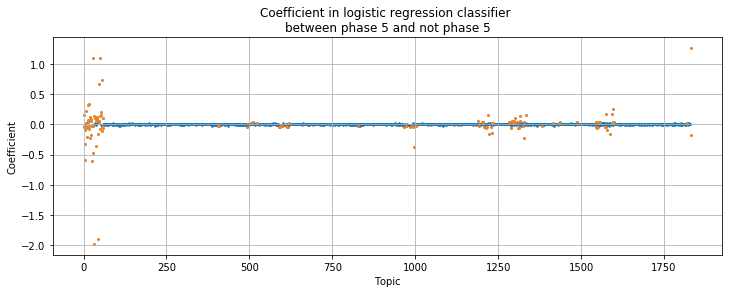

In [38]:
f = plt.figure(figsize=(12,4))
plt.scatter(range(len(clf.coef_[0])),clf.coef_[0],s=2.3)
out_std = [x for x in clf.coef_[0] if np.abs(x) > 0.025]
out_std_i = [i for i,x in enumerate(clf.coef_[0]) if np.abs(x) > 0.025]
plt.scatter(out_std_i,out_std,s=2.8)
#plt.xticks(range(0,len(clf.coef_[0])+1,2),rotation=90)
#plt.ylim(-1,1)
plt.xlabel('Topic')
plt.ylabel('Coefficient')
plt.title('Coefficient in logistic regression classifier \nbetween phase 5 and not phase 5')
plt.grid()

In [39]:
np.round(np.mean(clf.coef_[0]),4)
np.std(clf.coef_[0])

0.09084346287563434

### Important Topics

In [40]:
a_name = 'lda_textbooks_chunksize_alpha_auto_seed_{}_{}_{}_{}.pickle'.format(SEED,num_topics,REMOVE_STOPWORDS,WITH_STEMMING)
model_file = os.path.join(results_path,'lda_models',a_name)
with open(model_file,'rb') as f:
    ldamodel = pickle.load(f)

C:\Users\CATALINA ESPINOZA\AppData\Local\conda\conda\envs\teacher_topic_model\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [41]:
les_ids = np.argsort(np.abs(clf.coef_[0]))[-20:]

In [42]:
list(zip(np.argsort(np.abs(clf.coef_[0]))[-20:],clf.coef_[0][les_ids]))

[(10, -0.20299456503658025),
 (8, 0.2166735074072984),
 (1328, -0.22870422517519734),
 (20, -0.23399317109910173),
 (1595, 0.25967726901265403),
 (5, -0.3206392595944343),
 (13, 0.32335771354137455),
 (17, 0.33137043659240656),
 (39, -0.3618428268739139),
 (996, -0.37388782478029287),
 (29, -0.482812251976258),
 (3, -0.5930716920515201),
 (26, -0.6075927292975426),
 (48, 0.676294269846098),
 (55, 0.7354913533876611),
 (30, 1.0980529135154093),
 (50, 1.1040373195660929),
 (1831, 1.2630133140118296),
 (43, -1.9041577248483603),
 (33, -1.98297287756983)]

In [43]:
print(df.columns[996])
print(df.columns[1830+7])
print(df.columns[1831+7])

Topic 44-Topic 34
length utterance
utterance_relative_time


Topics

In [44]:
ldamodel.show_topic(33)

[('NUMBER', 0.6798587),
 ('a', 0.08793937),
 ('b', 0.07294916),
 ('c', 0.04292229),
 ('d', 0.022924542),
 ('lask', 0.007425218),
 ('+', 0.005417729),
 ('yhtälö', 0.003409941),
 ('kirj', 0.00226472),
 ('A_NAME', 0.002003389)]

In [45]:
ldamodel.show_topic(43)

[('EQUAL_SYMBOL', 0.16383563),
 ('n', 0.10167014),
 ('e', 0.08339013),
 ('NUMBER', 0.07767182),
 ('v', 0.050334003),
 ('k', 0.05002136),
 ('s', 0.045941617),
 ('m', 0.044747524),
 ('T_', 0.04445801),
 ('o', 0.035047248)]

In [131]:
ldamodel.show_topic(30)

[('a', 0.0762239),
 ('b', 0.031992134),
 ('c', 0.026608875),
 ('e', 0.023899583),
 ('oike', 0.01626492),
 ('kuva', 0.014383731),
 ('rin', 0.014164257),
 ('tulo', 0.012914545),
 ('kirj', 0.012067141),
 ('suuremp', 0.0119486265)]

### Plot phrases

In [46]:
print(len(X_train))
print(len(X_train[0]))

363
1832


In [47]:
amat2 = np.ones((len(X_train[0]),len(X_train)))
for i in range(len(X_train[0])):
    lali = []
    for element in X_train:
        lali.append(element[i])
    amat2[i,:] =np.array(lali)
    
means = [np.mean(amat2[i]) for i in range(len(X_train[0]))]

X_train_centered = []
for i in range(len(X_train)):
    row = []
    for j in range(len(X_train[0])):
        row.append(X_train[i][j]-means[j])
    X_train_centered.append(row)

In [48]:
# make 3-class dataset for classification
pca = PCA(n_components=2)
pca.fit(X_train_centered)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [49]:
sum(pca.explained_variance_ratio_)

0.6441700362327367

In [50]:
v_1 = pca.components_[0]
v_2 = pca.components_[1]

In [51]:
np.argsort(np.abs(v_1))

array([ 243, 1482,  988, ...,   10,   33, 1831], dtype=int64)

In [52]:
v_1[np.argsort(np.abs(v_1))]

array([-4.15427890e-09, -2.10509570e-08,  2.93333695e-08, ...,
       -2.14599095e-02, -2.79547344e-02, -9.98305848e-01])

In [53]:
v_2[np.argsort(v_2)]

array([-0.29837755, -0.07242681, -0.03486535, ...,  0.20446555,
        0.31371717,  0.86295282])

In [54]:
len(X_train)

363

In [55]:
Xdot = np.dot(X_train_centered,pca.components_.T)

In [56]:
pca.components_.shape
Xdot.shape

(363, 2)

In [57]:
colors = {0:'purple',1:'r',2:'b',3:'g',4:'y',5:'black'}


In [58]:
Xdot

array([[ 4.82320728e-01,  2.77341505e-02],
       [ 3.82428237e-01, -3.33513338e-02],
       [ 3.42477963e-01, -8.55288123e-02],
       [ 4.87408263e-01, -1.74592872e-01],
       [ 4.72495528e-01, -8.02559803e-02],
       [ 4.51651151e-01,  5.19090280e-03],
       [ 3.83977866e-01,  6.80936597e-02],
       [ 3.64879991e-01, -5.65483897e-02],
       [ 3.52282452e-01,  2.18579292e-01],
       [ 2.91757715e-01,  3.78364326e-02],
       [ 2.74303890e-01,  2.46808690e-01],
       [ 2.19797600e-01,  1.79659987e-01],
       [ 1.83415671e-01,  8.19146223e-02],
       [ 1.09890824e-01, -1.57833448e-02],
       [ 6.96807022e-02, -1.41582706e-02],
       [-2.28554716e-01,  1.17767950e-03],
       [-2.63756676e-01,  2.12328884e-02],
       [ 4.94815414e-01,  1.21681837e-02],
       [ 4.57391123e-01, -3.67615193e-02],
       [ 4.04581813e-01,  2.26307851e-01],
       [ 2.98472908e-01,  2.18385237e-01],
       [ 2.77006222e-01, -4.21689499e-02],
       [ 1.26112641e-02, -1.35503327e-01],
       [-1.

(array([ 48., 137., 120.,  36.,  14.,   3.,   2.,   2.,   0.,   1.]),
 array([-0.20930227, -0.1095419 , -0.00978154,  0.08997883,  0.18973919,
         0.28949956,  0.38925993,  0.48902029,  0.58878066,  0.68854103,
         0.78830139]),
 <a list of 10 Patch objects>)

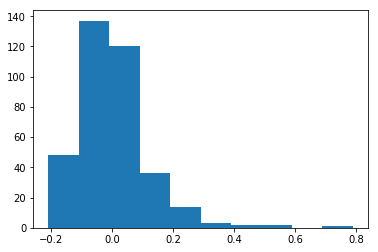

In [59]:
plt.hist([x[1] for x in Xdot])

In [60]:
X_train,y_train1 = get_data_from_dict_filter(trainset,1)
X_train,y_train2 = get_data_from_dict_filter(trainset,2)
X_train,y_train3 = get_data_from_dict_filter(trainset,3)
X_train,y_train4 = get_data_from_dict_filter(trainset,4)
X_train,y_train5 = get_data_from_dict_filter(trainset,5)

In [61]:
y_train2 = np.array(y_train1)+np.array(y_train2)+np.array(y_train3)+np.array(y_train4)+np.array(y_train5)

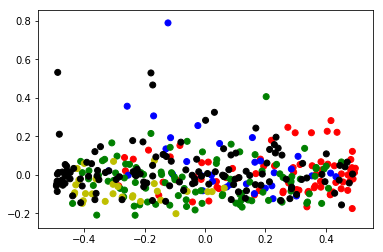

In [62]:

color_label = [colors[i] for i in y_train2]
plt.scatter([x[0] for x in Xdot],[x[1] for x in Xdot],color=color_label)
#plt.ylim(-0.2,0.5)